In [1]:
import os
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols
from  statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# random seed
random_state=0
rng = np.random.RandomState(seed=random_state)

C:\Users\chris\Anaconda3\envs\mlp\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
def mape(true, predicted):
    return np.mean(abs(((true - predicted)/true))) * (100)

def stdape(true,predicted):
    return np.std(abs(((true - predicted)/true))) * 100

## Load and process data

In [5]:
#load dataset
data_process = pd.read_csv('clean_houses_95.csv',parse_dates=['Time'], index_col='Time')
data = data_process.copy(deep=True)

In [6]:
data.describe()

,House_1,House_2,House_4,House_5,House_6,House_7,House_8,House_9,House_10,House_12,House_13,House_15,House_16,House_17,House_18,House_19,House_20
count,12844.000000,10786.000000,12904.000000,13808.000000,11237.000000,12282.000000,11402.000000,11002.000000,12523.000000,10435.000000,8964.000000,11523.000000,10597.000000,10100.000000,9539.000000,10111.000000,9891.000000
mean,0.412006,0.357511,0.341143,0.654149,0.439971,0.468798,0.561477,0.464550,0.691112,0.307838,0.458776,0.216673,0.487613,0.321604,0.391240,0.256221,0.331514
std,0.284248,0.355437,0.135901,0.396728,0.182272,0.416472,0.429591,0.411350,0.551520,0.215136,0.350934,0.081999,0.276190,0.234905,0.163350,0.117051,0.164856
min,0.152000,0.052667,0.000000,0.127994,0.177595,0.092454,0.175323,0.107652,0.152500,0.123012,0.119870,0.072198,0.134351,0.115270,0.000000,0.131496,0.117722
25%,0.204036,0.122738,0.238103,0.345386,0.269982,0.168006,0.235547,0.176723,0.288828,0.155386,0.227653,0.162158,0.282523,0.177660,0.279276,0.165967,0.202034
50%,0.279732,0.185790,0.321434,0.538340,0.404851,0.233449,0.423248,0.238599,0.475191,0.208050,0.318241,0.178023,0.402364,0.233759,0.348697,0.210723,0.274244
75%,0.544857,0.446576,0.431228,0.849480,0.581491,0.685734,0.711342,0.660695,0.894842,0.378606,0.547833,0.252352,0.606807,0.359993,0.466000,0.314077,0.434960
max,1.382292,1.679221,0.756389,1.857446,0.920802,1.782699,2.391865,1.966144,2.169000,1.086158,1.822713,0.517512,1.417603,1.375439,1.123081,0.653684,0.938697


In [7]:
#load weather data
weather_process = pd.read_csv('weather_data.csv',parse_dates=True, index_col='dateTime')

In [8]:
# keep the same time frame for weather data and resample on hourly level by averaging
weather = weather_process.copy(deep=True)
cols = ['Wind_speed','Wind_direction_D1', 'Wind_direction_SD1', 'Average_horizontal_solar_irradiance', 'NR_Wm2_Avg', 'CNR_Wm2_Avg', 'Average_barometric_pressure']
weather = weather.drop(cols,axis=1)
weather = weather['2014-04':]
weather = weather.resample('H').mean()

In [9]:
scaler = StandardScaler()
weather[['Air_temperature','Relative_humidity', 'Total_horizontal_solar_irradiation','Total_rainfall']] = scaler.fit_transform(weather[['Air_temperature','Relative_humidity', 'Total_horizontal_solar_irradiation','Total_rainfall']])

In [10]:
data = data['2014-04':]

In [11]:
# Create seasonal variables
#data['Year'] = pd.DatetimeIndex(data.index).year
data['Month'] = pd.DatetimeIndex(data.index).month
data['Week'] = pd.DatetimeIndex(data.index).week
data['DayOfMonth'] = pd.DatetimeIndex(data.index).day
#data['DayOfWeek'] =  pd.DatetimeIndex(data.index).dayofweek
data['Day'] = pd.DatetimeIndex(data.index).weekday_name
data['Hour'] =  pd.DatetimeIndex(data.index).hour

# create weather variables
data = pd.concat([data,weather], axis=1)

## Create seasonal variables

In [12]:
# Week days Feature
data.loc[(data['Day'] == 'Monday', 'WeekDays')] = 'WeekDays'
data.loc[(data['Day'] == 'Saturday', 'WeekDays')] = 'Saturday'
data.loc[(data['Day'] == 'Sunday', 'WeekDays')] = 'Sunday'
data.loc[(data['Day'] == 'Tuesday', 'WeekDays')] = 'WeekDays'
data.loc[(data['Day'] == 'Wednesday', 'WeekDays')] = 'WeekDays'
data.loc[(data['Day'] == 'Thursday', 'WeekDays')] = 'WeekDays'
data.loc[(data['Day'] == 'Friday', 'WeekDays')] = 'WeekDays'

In [13]:
# Season feature
data.loc[ (data['Month'] == 1), 'Season'] = 'Winter'
data.loc[ (data['Month'] == 2), 'Season'] = 'Winter'
data.loc[ (data['Month'] == 12), 'Season'] = 'Winter'
data.loc[ (data['Month'] == 3),  'Season'] = 'Spring'
data.loc[ (data['Month'] == 4),  'Season'] = 'Spring'
data.loc[ (data['Month'] == 5),  'Season'] = 'Spring'
data.loc[ (data['Month'] == 6), 'Season'] = 'Summer'
data.loc[ (data['Month'] == 7), 'Season'] = 'Summer'
data.loc[ (data['Month'] == 8), 'Season'] = 'Summer'
data.loc[ (data['Month'] == 9), 'Season'] = 'Autumn' 
data.loc[ (data['Month'] == 10), 'Season'] = 'Autumn' 
data.loc[ (data['Month'] == 11), 'Season'] = 'Autumn' 

In [14]:
# Time bulk feature
time_bulk_1 = [1,2,3,4]
time_bulk_2 = [5,6,7,8]
time_bulk_3 = [9,10,11,12]
time_bulk_4 = [13,14,15,16]
time_bulk_5 = [17,18,19,20]
time_bulk_6 = [21,22,23,0]
for i in range(0,24):
    if i in time_bulk_1:
        data.loc[(data['Hour'] == i), 'Time_bulk'] = 'Midnight'
    elif i in time_bulk_2:
        data.loc[(data['Hour']== i), 'Time_bulk'] = 'Morning'
    elif i in time_bulk_3:
        data.loc[(data['Hour']== i), 'Time_bulk'] = 'Noon'
    elif i in time_bulk_4:
        data.loc[(data['Hour']== i), 'Time_bulk'] = 'Afternoon'
    elif i in time_bulk_5:
        data.loc[(data['Hour']== i), 'Time_bulk'] = 'Evening'
    else:
        data.loc[(data['Hour']== i), 'Time_bulk'] = 'Night'

In [15]:
# create trend 
data = data.assign(Trend = pd.Series(np.arange(len(data))+1).values)

In [16]:
# create trend square
x = (np.arange(data.shape[0]))**2 + 1
data = data.assign(Trend_square = pd.Series(x).values)

## Prepare data for modeling

In [17]:
data_modeling = data.copy(deep=True)

In [18]:
data_modeling.columns

Index(['House_1', 'House_2', 'House_4', 'House_5', 'House_6', 'House_7',
       'House_8', 'House_9', 'House_10', 'House_12', 'House_13', 'House_15',
       'House_16', 'House_17', 'House_18', 'House_19', 'House_20', 'Month',
       'Week', 'DayOfMonth', 'Day', 'Hour', 'Air_temperature',
       'Relative_humidity', 'Total_horizontal_solar_irradiation',
       'Total_rainfall', 'WeekDays', 'Season', 'Time_bulk', 'Trend',
       'Trend_square'],
      dtype='object')

In [19]:
# drop unwanted features
cols = ['Week','WeekDays','Season','Time_bulk','Trend','Trend_square']
data_modeling = data_modeling.drop(cols, axis=1)

In [20]:
data_modeling.columns

Index(['House_1', 'House_2', 'House_4', 'House_5', 'House_6', 'House_7',
       'House_8', 'House_9', 'House_10', 'House_12', 'House_13', 'House_15',
       'House_16', 'House_17', 'House_18', 'House_19', 'House_20', 'Month',
       'DayOfMonth', 'Day', 'Hour', 'Air_temperature', 'Relative_humidity',
       'Total_horizontal_solar_irradiation', 'Total_rainfall'],
      dtype='object')

In [21]:
# columns for one hot encoding
cols =  ['Month','DayOfMonth', 'Hour', 'Day']

In [22]:
data_modeling.House_18 = data_modeling.House_18.replace(0.0, np.nan)

## Linear Regression model

In [18]:
houses=[1,2,4,5,6,7,8,9,10,12,13,15,16,17,18,19,20]
thesaurus = {}
all_results=pd.DataFrame()

for house_nr in houses:
    #create dummy variables
    data_ook = pd.get_dummies(data_modeling, columns=cols, prefix=cols, drop_first=True)
    data_ook = pd.get_dummies(data_ook, columns=['Month'], prefix='Month', drop_first=False)
    
    # keep the house you want for modeling
    drop_houses = ['House_'+str(i) for i in houses if i != house_nr]
    data_ook = data_ook.drop(drop_houses, axis=1)

    # drop nan values
    data_ook = data_ook.dropna(axis=0,how='any')

    # split train and test sets
    house = 'House_' + str(house_nr)
    x = data_ook.drop(house,axis=1).values.astype(np.float)
    y = data_ook[house].values
    
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
    
    
    
    
    # train the model
    model = sm.OLS(endog=y_train,exog=x_train)
    results = model.fit()
    fit = results.fittedvalues
    
    form = 'House_' + str(house_nr) + ' ~ C(Month) + C(DayOfMonth) + C(WeekDays) + C(Hour) -1'
    mod = ols(formula=form, data=data_modeling, missing='drop').fit()
    anova = sm.stats.anova_lm(mod, typ=2)
    
    # save results from training time
    key= 'House'
    thesaurus[key] = house_nr
    key = 'train_r_squared'
    thesaurus[key] = results.rsquared
    key = 'train_r_squared_adj'
    thesaurus[key] = results.rsquared_adj
    key = 'train_' + 'mse'
    thesaurus[key] = mean_squared_error(y_true=y_train, y_pred=fit)
    key = 'train_' + 'mae'
    thesaurus[key] = mean_absolute_error(y_true=y_train, y_pred=fit)
    key = 'train_' + 'mde'
    thesaurus[key] = median_absolute_error(y_true=y_train, y_pred=fit)
    key = 'train_' + 'mape'
    thesaurus[key] = mape(y_train, fit)
    key = 'train_' + 'stdape'
    thesaurus[key] = stdape(y_train, fit)
    key = 'train_F_Month'
    thesaurus[key] = anova['F'][0]
    key = 'train_F_DayOfMonth'
    thesaurus[key] = anova['F'][1]
    key = 'train_F_WeekDays'
    thesaurus[key] = anova['F'][2]
    key = 'train_F_Hour'
    thesaurus[key] = anova['F'][3]
    key = 'train_PF_Month'
    thesaurus[key] = anova['PR(>F)'][0]
    key = 'train_PF_DayOfMonth'
    thesaurus[key] = anova['PR(>F)'][1]
    key = 'train_PF_WeekDays'
    thesaurus[key] = anova['PR(>F)'][2]
    key = 'train_PF_Hour'
    thesaurus[key] = anova['PR(>F)'][3]
    key = 'train_sq_Month'
    thesaurus[key] = anova['sum_sq'][0]
    key = 'train_sq_DayOfMonth'
    thesaurus[key] = anova['sum_sq'][1]
    key = 'train_sq_WeekDays'
    thesaurus[key] = anova['sum_sq'][2]
    key = 'train_sq_Hour'
    thesaurus[key] = anova['sum_sq'][3]
    
    
    # save results from testing time with rolling forecasting time technique

    predictions = results.predict(x_test)
    
    key = 'test_r_squared'
    thesaurus[key] = r2_score(y_true=y_test,y_pred=predictions)
    key = 'test_r_squared_adj'
    thesaurus[key] = 1 - (1-r2_score(y_true=y_test,y_pred=predictions))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
    key = 'test_' + 'mse'
    thesaurus[key] = mean_squared_error(y_true=y_test, y_pred=predictions)
    key = 'test_' + 'mae'
    thesaurus[key] = mean_absolute_error(y_true=y_test, y_pred=predictions)
    key = 'test_' + 'mde'
    thesaurus[key] = median_absolute_error(y_true=y_test, y_pred=predictions)
    key = 'test_' + 'mape'
    thesaurus[key] = mape(y_test, predictions)
    key = 'test_' + 'stdape'
    thesaurus[key] = stdape(y_test, predictions)
    
    df1  = pd.DataFrame(thesaurus, index=[house_nr])
    all_results = pd.concat([all_results,df1])

In [20]:
all_results

,House,test_mae,test_mape,test_mde,test_mse,test_r_squared,test_r_squared_adj,test_stdape,train_F_DayOfMonth,train_F_Hour,...,train_mape,train_mde,train_mse,train_r_squared,train_r_squared_adj,train_sq_DayOfMonth,train_sq_Hour,train_sq_Month,train_sq_WeekDays,train_stdape
1,1,0.178967,52.235575,0.130949,0.061578,0.115792,0.091651,39.591655,3.435350,18.267633,...,52.322206,0.132900,0.057183,0.140348,0.132781,6.030216,24.583895,73.024904,0.696957,40.071536
2,2,0.222111,87.056806,0.144349,0.104265,0.240094,0.216761,99.064561,4.992025,98.341943,...,86.201331,0.143371,0.091891,0.261228,0.253932,14.293578,215.878568,72.547132,0.349610,97.912065
4,4,0.087732,30.605260,0.071534,0.012646,0.273518,0.252884,31.303458,2.202778,156.768364,...,31.266847,0.071701,0.012355,0.285337,0.278799,0.824949,45.011299,16.650833,0.070185,33.543347
5,5,0.266374,52.698633,0.215471,0.118248,0.223799,0.202335,61.179030,4.047185,88.651788,...,50.247485,0.210186,0.111634,0.249562,0.242874,13.804344,231.823137,124.409816,58.339945,57.170681
6,6,0.103437,26.506716,0.073961,0.019317,0.399321,0.381677,29.059392,5.922642,243.822752,...,27.114253,0.077358,0.019933,0.393063,0.387323,3.534026,111.541117,23.806624,0.350051,28.400947
7,7,0.227111,70.200541,0.169120,0.096859,0.349705,0.331648,70.590528,4.780833,221.162890,...,71.796076,0.169738,0.105135,0.362979,0.357278,14.850394,526.687788,50.485779,0.244125,70.899572
8,8,0.254758,61.546434,0.165050,0.140317,0.254657,0.231707,71.125945,3.021297,136.649615,...,59.546621,0.169104,0.129877,0.300136,0.293203,12.060371,418.198314,90.038098,0.278150,68.958409
9,9,0.234787,67.829398,0.156240,0.113152,0.354967,0.336363,69.517795,1.839077,220.376238,...,67.075996,0.152611,0.114500,0.365965,0.360075,6.330179,581.550525,43.883461,18.100111,69.764320
10,10,0.246830,50.617283,0.181617,0.116598,0.282765,0.262608,49.075953,3.090912,163.132196,...,50.882580,0.182555,0.117721,0.296955,0.290590,10.949724,443.060241,46.340772,1.150843,48.528173
12,12,0.129065,44.375928,0.091882,0.035253,0.267770,0.247346,42.763364,1.417606,155.844357,...,43.932161,0.085651,0.032655,0.275611,0.269098,1.422337,119.879493,8.443047,0.581473,43.204422


In [21]:
all_results.to_csv('results_linear_regression.csv')

## Linear Regression Model with Weather Variables

In [24]:
houses=[1,2,4,5,6,7,8,9,10,12,13,15,16,17,18,19,20]
thesaurus = {}
all_results=pd.DataFrame()

for house_nr in houses:
    #create dummy variables
    data_ook = pd.get_dummies(data_modeling, columns=cols, prefix=cols, drop_first=True)
    data_ook = pd.get_dummies(data_ook, columns=['Month'], prefix='Month', drop_first=False)
    
    # keep the house you want for modeling
    drop_houses = ['House_'+str(i) for i in houses if i != house_nr]
    data_ook = data_ook.drop(drop_houses, axis=1)

    # drop nan values
    data_ook = data_ook.dropna(axis=0,how='any')

    # split train and test sets
    house = 'House_' + str(house_nr)
    x = data_ook.drop(house,axis=1).values.astype(np.float)
    y = data_ook[house].values
    
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
    
    
    
    
    # train the model
    model = sm.OLS(endog=y_train,exog=x_train)
    results = model.fit()
    fit = results.fittedvalues
    
    form = 'House_' + str(house_nr) + ' ~ C(Month) + C(DayOfMonth) + C(WeekDays) + C(Hour) + Air_temperature + Relative_humidity +Total_horizontal_solar_irradiation + Total_rainfall  -1'
    mod = ols(formula=form, data=data_modeling, missing='drop').fit()
    anova = sm.stats.anova_lm(mod, typ=2)
    
    # save results from training time
    key= 'House'
    thesaurus[key] = house_nr
    key = 'train_r_squared'
    thesaurus[key] = results.rsquared
    key = 'train_r_squared_adj'
    thesaurus[key] = results.rsquared_adj
    key = 'train_' + 'mse'
    thesaurus[key] = mean_squared_error(y_true=y_train, y_pred=fit)
    key = 'train_' + 'mae'
    thesaurus[key] = mean_absolute_error(y_true=y_train, y_pred=fit)
    key = 'train_' + 'mde'
    thesaurus[key] = median_absolute_error(y_true=y_train, y_pred=fit)
    key = 'train_' + 'mape'
    thesaurus[key] = mape(y_train, fit)
    key = 'train_' + 'stdape'
    thesaurus[key] = stdape(y_train, fit)
    key = 'train_F_Month'
    thesaurus[key] = anova['F'][0]
    key = 'train_F_DayOfMonth'
    thesaurus[key] = anova['F'][1]
    key = 'train_F_WeekDays'
    thesaurus[key] = anova['F'][2]
    key = 'train_F_Hour'
    thesaurus[key] = anova['F'][3]
    key = 'train_F_AirTemperature'
    thesaurus[key] = anova['F'][4]
    key = 'train_F_Relative_humitidity'
    thesaurus[key] = anova['F'][5]
    key = 'train_F_Total_horizontal_solar_irradiation'
    thesaurus[key] = anova['F'][6]
    key = 'train_F_Total_rainfall'
    thesaurus[key] = anova['F'][7]
    key = 'train_PF_Month'
    thesaurus[key] = anova['PR(>F)'][0]
    key = 'train_PF_DayOfMonth'
    thesaurus[key] = anova['PR(>F)'][1]
    key = 'train_PF_WeekDays'
    thesaurus[key] = anova['PR(>F)'][2]
    key = 'train_PF_Hour'
    thesaurus[key] = anova['PR(>F)'][3]
    key = 'train_PF_AirTemperature'
    thesaurus[key] = anova['PR(>F)'][4]
    key = 'train_PF_Relative_humitidity'
    thesaurus[key] = anova['PR(>F)'][5]
    key = 'train_PF_Total_horizontal_solar_irradiation'
    thesaurus[key] = anova['PR(>F)'][6]
    key = 'train_PF_Total_rainfall'
    thesaurus[key] = anova['PR(>F)'][7]
    key = 'train_sq_Month'
    thesaurus[key] = anova['sum_sq'][0]
    key = 'train_sq_DayOfMonth'
    thesaurus[key] = anova['sum_sq'][1]
    key = 'train_sq_WeekDays'
    thesaurus[key] = anova['sum_sq'][2]
    key = 'train_sq_Hour'
    thesaurus[key] = anova['sum_sq'][3]
    key = 'train_sq_AirTemperature'
    thesaurus[key] = anova['sum_sq'][4]
    key = 'train_sq_Relative_humitidity'
    thesaurus[key] = anova['sum_sq'][5]
    key = 'train_sq_Total_horizontal_solar_irradiation'
    thesaurus[key] = anova['sum_sq'][6]
    key = 'train_sq_Total_rainfall'
    thesaurus[key] = anova['sum_sq'][7]
    
    
    # save results from testing time with rolling forecasting time technique

    predictions = results.predict(x_test)
    
    key = 'test_r_squared'
    thesaurus[key] = r2_score(y_true=y_test,y_pred=predictions)
    key = 'test_r_squared_adj'
    thesaurus[key] = 1 - (1-r2_score(y_true=y_test,y_pred=predictions))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
    key = 'test_' + 'mse'
    thesaurus[key] = mean_squared_error(y_true=y_test, y_pred=predictions)
    key = 'test_' + 'mae'
    thesaurus[key] = mean_absolute_error(y_true=y_test, y_pred=predictions)
    key = 'test_' + 'mde'
    thesaurus[key] = median_absolute_error(y_true=y_test, y_pred=predictions)
    key = 'test_' + 'mape'
    thesaurus[key] = mape(y_test, predictions)
    key = 'test_' + 'stdape'
    thesaurus[key] = stdape(y_test, predictions)
    
    df1  = pd.DataFrame(thesaurus, index=[house_nr])
    all_results = pd.concat([all_results,df1])

In [25]:
all_results

,House,test_mae,test_mape,test_mde,test_mse,test_r_squared,test_r_squared_adj,test_stdape,train_F_AirTemperature,train_F_DayOfMonth,...,train_r_squared_adj,train_sq_AirTemperature,train_sq_DayOfMonth,train_sq_Hour,train_sq_Month,train_sq_Relative_humitidity,train_sq_Total_horizontal_solar_irradiation,train_sq_Total_rainfall,train_sq_WeekDays,train_stdape
1,1,0.181865,53.343661,0.138438,0.063595,0.127871,0.100497,42.127739,2.934384,4.110145,...,0.139554,0.174511,7.333052,29.285508,35.894878,0.053633,2.647075,0.110293,0.669910,41.026246
2,2,0.223145,87.910561,0.144049,0.104546,0.238044,0.213205,99.613405,4.730395,4.902340,...,0.256394,0.450614,14.009795,190.643399,36.407641,0.648650,0.757229,0.619974,0.361076,98.247845
4,4,0.088127,30.046517,0.072536,0.012800,0.289845,0.267315,30.079863,1.499990,2.315296,...,0.290243,0.018417,0.852810,40.221538,14.239091,0.893675,0.001918,0.010315,0.071836,33.288200
5,5,0.265088,53.630040,0.218344,0.114980,0.218652,0.194062,60.175716,7.847249,4.569725,...,0.250879,0.911215,15.918957,217.103111,72.890939,0.582157,0.108596,0.045777,55.433062,56.771385
6,6,0.104258,26.688371,0.071971,0.019455,0.409163,0.389956,29.030731,1.292837,5.244636,...,0.410334,0.024650,2.999883,90.151098,20.626734,0.023033,0.243476,0.025441,0.342953,28.679583
7,7,0.234082,69.145876,0.162517,0.104185,0.367688,0.347610,68.496548,16.151543,4.890325,...,0.360275,1.692527,15.373774,436.833523,16.465349,2.429099,0.803571,0.020549,0.217678,71.910354
8,8,0.253882,61.121533,0.165814,0.139161,0.260794,0.236631,70.440003,37.408344,3.173440,...,0.297857,4.942055,12.577392,332.923114,43.312684,0.116868,0.455986,4.111831,0.343115,68.442998
9,9,0.240024,67.475256,0.154405,0.121905,0.346134,0.324501,71.063324,3.295478,1.891999,...,0.366358,0.380335,6.550732,502.602937,33.725959,2.565686,0.583846,0.985845,16.090159,68.386670
10,10,0.245231,50.980182,0.177723,0.116838,0.302649,0.280663,49.625618,2.944904,3.751085,...,0.310659,0.352955,13.487344,425.412152,25.753715,8.234095,0.066039,0.156845,1.367876,50.361947
12,12,0.126675,44.480650,0.085047,0.034166,0.268752,0.245471,43.535855,4.150947,1.674026,...,0.271077,0.139206,1.684199,104.524098,6.163470,0.327482,0.428319,0.060191,0.692626,43.530698


In [26]:
all_results.to_csv('results_linear_weather.csv')

## Dynamic model with exogenous variables

In [18]:
houses=[1,2,4,5,6,7,8,9,10,12,13,15,16,17,18,19,20]
thesaurus = {}
all_results=pd.DataFrame()

for house_nr in houses:
    data_copied = data_modeling.copy(deep=True)
    
    #create dummy variables
    data_ook = pd.get_dummies(data_modeling, columns=cols, prefix=cols, drop_first=True)
    data_ook = pd.get_dummies(data_ook, columns=['Month'], prefix='Month', drop_first=False)
    
    # keep the house you want for modeling
    drop_houses = ['House_'+str(i) for i in houses if i != house_nr]
    data_ook = data_ook.drop(drop_houses, axis=1)
    data_copied = data_copied.drop(drop_houses, axis=1)
    
    # create lagged predictors
    data_copied['t1'] = data_copied['House_'+str(house_nr)].shift(+1)
    data_copied['t24'] = data_copied['House_'+str(house_nr)].shift(+24)
    data_ook['t1'] = data_ook['House_'+str(house_nr)].shift(+1)
    data_ook['t24'] = data_ook['House_'+str(house_nr)].shift(+24)

    # drop nan values
    data_ook = data_ook.dropna(axis=0,how='any')
    data_copied = data_copied.dropna(axis=0,how='any')
    

    # split train and test sets
    house = 'House_' + str(house_nr)
    x = data_ook.drop(house,axis=1).values.astype(np.float)
    y = data_ook[house].values
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
    
    # train the model
    model = sm.OLS(endog=y_train,exog=x_train)
    results = model.fit()
    fit = results.fittedvalues
    
    form = 'House_' + str(house_nr) + ' ~ C(Month) + C(DayOfMonth) + C(WeekDays) + C(Hour) + t1 + t24 -1'
    mod = ols(formula=form, data=data_copied, missing='drop').fit()
    anova = sm.stats.anova_lm(mod, typ=2)
    
    # save results from training time
    key= 'House'
    thesaurus[key] = house_nr
    key = 'train_r_squared'
    thesaurus[key] = results.rsquared
    key = 'train_r_squared_adj'
    thesaurus[key] = results.rsquared_adj
    key = 'train_' + 'mse'
    thesaurus[key] = mean_squared_error(y_true=y_train, y_pred=fit)
    key = 'train_' + 'mae'
    thesaurus[key] = mean_absolute_error(y_true=y_train, y_pred=fit)
    key = 'train_' + 'mde'
    thesaurus[key] = median_absolute_error(y_true=y_train, y_pred=fit)
    key = 'train_' + 'mape'
    thesaurus[key] = mape(y_train, fit)
    key = 'train_' + 'stdape'
    thesaurus[key] = stdape(y_train, fit)
    key = 'train_F_Month'
    thesaurus[key] = anova['F'][0]
    key = 'train_F_DayOfMonth'
    thesaurus[key] = anova['F'][1]
    key = 'train_F_WeekDays'
    thesaurus[key] = anova['F'][2]
    key = 'train_F_Hour'
    thesaurus[key] = anova['F'][3]
    key = 'train_F_t1'
    thesaurus[key] = anova['F'][4]
    key = 'train_F_t24'
    thesaurus[key] = anova['F'][5]
    key = 'train_PF_Month'
    thesaurus[key] = anova['PR(>F)'][0]
    key = 'train_PF_DayOfMonth'
    thesaurus[key] = anova['PR(>F)'][1]
    key = 'train_PF_WeekDays'
    thesaurus[key] = anova['PR(>F)'][2]
    key = 'train_PF_Hour'
    thesaurus[key] = anova['PR(>F)'][3]
    key = 'train_PF_t1'
    thesaurus[key] = anova['PR(>F)'][4]
    key = 'train_PF_t24'
    thesaurus[key] = anova['PR(>F)'][5]
    key = 'train_sq_Month'
    thesaurus[key] = anova['sum_sq'][0]
    key = 'train_sq_DayOfMonth'
    thesaurus[key] = anova['sum_sq'][1]
    key = 'train_sq_WeekDays'
    thesaurus[key] = anova['sum_sq'][2]
    key = 'train_sq_Hour'
    thesaurus[key] = anova['sum_sq'][3]
    key = 'train_sq_t1'
    thesaurus[key] = anova['sum_sq'][4]
    key = 'train_sq_t24'
    thesaurus[key] = anova['sum_sq'][5]
    
    
    # save results from testing time with rolling forecasting time technique

    predictions = results.predict(x_test)
    
    key = 'test_r_squared'
    thesaurus[key] = r2_score(y_true=y_test,y_pred=predictions)
    key = 'test_r_squared_adj'
    thesaurus[key] = 1 - (1-r2_score(y_true=y_test,y_pred=predictions))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
    key = 'test_' + 'mse'
    thesaurus[key] = mean_squared_error(y_true=y_test, y_pred=predictions)
    key = 'test_' + 'mae'
    thesaurus[key] = mean_absolute_error(y_true=y_test, y_pred=predictions)
    key = 'test_' + 'mde'
    thesaurus[key] = median_absolute_error(y_true=y_test, y_pred=predictions)
    key = 'test_' + 'mape'
    thesaurus[key] = mape(y_test, predictions)
    key = 'test_' + 'stdape'
    thesaurus[key] = stdape(y_test, predictions)
    
    df1  = pd.DataFrame(thesaurus, index=[house_nr])
    all_results = pd.concat([all_results,df1])

In [19]:
all_results

,House,test_mae,test_mape,test_mde,test_mse,test_r_squared,test_r_squared_adj,test_stdape,train_F_DayOfMonth,train_F_Hour,...,train_mse,train_r_squared,train_r_squared_adj,train_sq_DayOfMonth,train_sq_Hour,train_sq_Month,train_sq_WeekDays,train_sq_t1,train_sq_t24,train_stdape
1,1,0.135517,39.602279,0.083189,0.042856,0.312054,0.291189,38.475065,1.147296,9.110717,...,0.041685,0.332958,0.326443,1.452631,8.843805,6.900958,0.368102,53.899682,33.243210,34.892491
2,2,0.174195,65.570635,0.097669,0.073588,0.363471,0.340959,78.210567,1.899426,33.557641,...,0.067021,0.411001,0.404317,3.924730,53.160051,9.049915,0.038023,112.209751,10.844576,75.396464
4,4,0.084468,30.118399,0.069074,0.011817,0.289366,0.266171,30.636396,1.510538,66.149243,...,0.011578,0.283571,0.276054,0.530120,17.798115,8.741517,0.059832,0.013395,1.929882,32.483635
5,5,0.202795,35.103217,0.144086,0.078478,0.412537,0.394079,31.074076,0.912680,30.760933,...,0.076273,0.437189,0.431502,2.112711,54.591817,14.892171,7.943981,197.312610,22.029400,32.290503
6,6,0.077301,18.521167,0.055665,0.011459,0.638835,0.626553,17.379759,1.585598,44.942786,...,0.011201,0.633205,0.629200,0.539237,11.717991,0.540364,0.016635,53.994409,1.254021,17.831947
7,7,0.183494,52.881877,0.108982,0.076347,0.466068,0.449152,56.742828,1.688538,60.418611,...,0.077381,0.457944,0.452422,3.924115,107.648545,6.306275,0.224855,131.636318,8.267168,57.128409
8,8,0.200901,47.581512,0.135003,0.088415,0.351170,0.328852,49.582860,1.816931,29.303522,...,0.098537,0.359162,0.352083,5.264441,65.093898,20.936540,0.028396,55.450462,65.780045,50.675066
9,9,0.189317,50.744601,0.107449,0.082358,0.486314,0.469323,56.694909,0.938745,54.596370,...,0.083929,0.467932,0.462278,2.365007,105.452087,5.347031,5.109571,133.852566,10.429121,59.828051
10,10,0.199220,38.809710,0.122343,0.089943,0.404766,0.385909,38.831228,1.024271,46.057493,...,0.087503,0.420720,0.414817,2.720862,93.799075,8.341707,0.366118,170.619791,7.451877,37.787212
12,12,0.104948,37.478595,0.063178,0.025770,0.347099,0.326067,38.850262,0.655065,50.407033,...,0.026164,0.353699,0.347006,0.515122,30.389472,1.898313,0.078602,29.000283,1.468887,38.000693


In [20]:
all_results.to_csv('results_dynamic_regression.csv')

## Random Forest Regressor

In [30]:
houses=[1,2,4,5,6,7,8,9,10,12,13,15,16,17,18,19,20]
thesaurus = {}
all_results=pd.DataFrame()

for house_nr in houses:
    
    #create dummy variables
    data_ook = pd.get_dummies(data_modeling, columns=cols, prefix=cols, drop_first=True)
    data_ook = pd.get_dummies(data_ook, columns=['Month'], prefix='Month', drop_first=False)
    
    # keep the house you want for modeling
    drop_houses = ['House_'+str(i) for i in houses if i != house_nr]
    data_ook = data_ook.drop(drop_houses, axis=1)
    
    # create lagged predictors
    data_ook['t1'] = data_ook['House_'+str(house_nr)].shift(+1)
    data_ook['t24'] = data_ook['House_'+str(house_nr)].shift(+24)

    # drop nan values
    data_ook = data_ook.dropna(axis=0,how='any')
    
    
    # split train and test sets
    house = 'House_' + str(house_nr)
    x = data_ook.drop(house,axis=1).values.astype(np.float)
    y = data_ook[house].values
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
    
    # fit random forest model
    model = RandomForestRegressor(n_estimators=500, max_features=x_train.shape[1], random_state=rng, oob_score=True, n_jobs=-1)
    results = model.fit(X=x_train, y=y_train)
    fit = model.predict(x_train)
    
    # create importance scores per variable
    DayOfMonth = model.feature_importances_[0:30].sum()
    Hour = model.feature_importances_[30:53].sum()
    WeekDays = model.feature_importances_[53:55].sum()
    Month = model.feature_importances_[55:67].sum()
    t1 = model.feature_importances_[67]
    t24 = model.feature_importances_[68]
    
    # save results from training time
    key= 'House'
    thesaurus[key] = house_nr
    key = 'train_r_squared'
    thesaurus[key] = r2_score(y_true=y_train,y_pred=fit)
    key = 'train_r_squared_adj'
    thesaurus[key] = 1 - (1-r2_score(y_true=y_train,y_pred=fit))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
    key = 'train_' + 'mse'
    thesaurus[key] = mean_squared_error(y_true=y_train, y_pred=fit)
    key = 'train_' + 'mae'
    thesaurus[key] = mean_absolute_error(y_true=y_train, y_pred=fit)
    key = 'train_' + 'mde'
    thesaurus[key] = median_absolute_error(y_true=y_train, y_pred=fit)
    key = 'train_' + 'mape'
    thesaurus[key] = mape(y_train, fit)
    key = 'train_' + 'stdape'
    thesaurus[key] = stdape(y_train, fit)
    key = 'importance_Month'
    thesaurus[key] = Month
    key = 'importance_DayOfMonth'
    thesaurus[key] = DayOfMonth
    key = 'importance_WeekDays'
    thesaurus[key] = WeekDays
    key = 'importance_Hour'
    thesaurus[key] = Hour
    key = 'importance_t1'
    thesaurus[key] = t1
    key = 'importance_t24'
    thesaurus[key] = t24
   
    
    
    # save results from testing time with rolling forecasting time technique

    predictions = model.predict(x_test)
    
    key = 'test_r_squared'
    thesaurus[key] = r2_score(y_true=y_test,y_pred=predictions)
    key = 'test_r_squared_adj'
    thesaurus[key] = 1 - (1-r2_score(y_true=y_test,y_pred=predictions))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
    key = 'test_' + 'mse'
    thesaurus[key] = mean_squared_error(y_true=y_test, y_pred=predictions)
    key = 'test_' + 'mae'
    thesaurus[key] = mean_absolute_error(y_true=y_test, y_pred=predictions)
    key = 'test_' + 'mde'
    thesaurus[key] = median_absolute_error(y_true=y_test, y_pred=predictions)
    key = 'test_' + 'mape'
    thesaurus[key] = mape(y_test, predictions)
    key = 'test_' + 'stdape'
    thesaurus[key] = stdape(y_test, predictions)
    key = 'oob_score'
    thesaurus[key] = model.oob_score_
    
    df1  = pd.DataFrame(thesaurus, index=[house_nr])
    all_results = pd.concat([all_results,df1])

In [35]:
all_results

,House,importance_DayOfMonth,importance_Hour,importance_Month,importance_WeekDays,importance_t1,importance_t24,oob_score,test_mae,test_mape,...,test_r_squared,test_r_squared_adj,test_stdape,train_mae,train_mape,train_mde,train_mse,train_r_squared,train_r_squared_adj,train_stdape
1,1,0.148395,0.162514,0.106953,0.017855,0.347662,0.216622,0.380492,0.118894,32.653053,...,0.354065,0.334474,37.375745,0.043774,11.869066,0.023086,0.005243,0.916104,0.915273,13.281476
2,2,0.136615,0.147537,0.089838,0.017180,0.456672,0.152157,0.419622,0.160245,53.277753,...,0.397102,0.375780,71.136417,0.056225,18.708491,0.022617,0.009040,0.920553,0.919638,27.231116
4,4,0.182966,0.206616,0.115910,0.022807,0.211411,0.260291,0.278860,0.080153,27.538026,...,0.312760,0.290328,28.663037,0.029918,10.540856,0.022721,0.001583,0.902042,0.900999,11.530009
5,5,0.126181,0.150617,0.078654,0.031597,0.472775,0.140176,0.475763,0.184553,28.212842,...,0.468789,0.452098,26.344670,0.067632,10.662669,0.045038,0.009657,0.928742,0.928012,10.504171
6,6,0.085879,0.098455,0.052208,0.010778,0.643980,0.108700,0.622977,0.074214,16.964757,...,0.630517,0.617952,18.056870,0.027277,6.307120,0.017329,0.001563,0.948803,0.948236,6.815702
7,7,0.140800,0.140647,0.089709,0.016867,0.416056,0.195921,0.431528,0.167898,42.266122,...,0.458473,0.441317,58.332500,0.062869,15.713127,0.024646,0.011043,0.922642,0.921843,22.460649
8,8,0.141310,0.181473,0.091047,0.022452,0.282778,0.280940,0.416287,0.177288,39.306105,...,0.436782,0.417409,45.611289,0.069703,14.864254,0.042120,0.012170,0.920853,0.919966,17.321630
9,9,0.136131,0.133788,0.075626,0.029978,0.464118,0.160360,0.449068,0.177441,42.501021,...,0.458679,0.440773,62.205622,0.063282,15.642706,0.024545,0.011781,0.925313,0.924508,23.839837
10,10,0.142824,0.148589,0.093238,0.018954,0.421956,0.174440,0.409473,0.194758,36.596399,...,0.382529,0.362967,41.654548,0.070505,13.227793,0.038670,0.012070,0.920093,0.919267,14.587615
12,12,0.174056,0.155750,0.098665,0.025854,0.355605,0.190070,0.294297,0.106004,36.351046,...,0.296656,0.273999,42.191125,0.038623,12.981869,0.021341,0.003861,0.904614,0.903611,15.439255


In [36]:
all_results.to_csv('results_forest_regression.csv')

# XGBoost

In [23]:
houses=[1,2,4,5,6,7,8,9,10,12,13,15,16,17,18,19,20]
thesaurus = {}
all_results=pd.DataFrame()

for house_nr in houses:
    
    #create dummy variables
    data_ook = pd.get_dummies(data_modeling, columns=cols, prefix=cols, drop_first=True)
    #data_ook = pd.get_dummies(data_ook, columns=['Month'], prefix='Month', drop_first=False)
    
    # keep the house you want for modeling
    drop_houses = ['House_'+str(i) for i in houses if i != house_nr]
    data_ook = data_ook.drop(drop_houses, axis=1)
    
    # create lagged predictors
    data_ook['t1'] = data_ook['House_'+str(house_nr)].shift(+1)
    data_ook['t24'] = data_ook['House_'+str(house_nr)].shift(+24)

    # drop nan values
    data_ook = data_ook.dropna(axis=0,how='any')
    
    
    # split train and test sets
    house = 'House_' + str(house_nr)
    x = data_ook.drop(house,axis=1).values.astype(np.float)
    y = data_ook[house].values
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
    
    
    # fit xgboost model
    d_train = xgb.DMatrix(x_train, label=y_train)
    d_test = xgb.DMatrix(x_test,label=y_test)
    
    params = {}
    params['eta'] = 0.02
    params['objective'] = 'reg:linear'
    params['eval_metric'] = 'mae'
    params['max_depth'] = 4
    params['silent'] = 1

    watchlist = [(d_train, 'train'), (d_test, 'valid')]
    model = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=100, verbose_eval=10)
    fit = model.predict(d_train)
    predictions = model.predict(d_test)
    
    # create importance scores per variable
    importances = model.get_fscore()
    air_temperature  = importances['f0']
    humidity = importances['f1']
    irradiation = importances['f2']
    rainfall = importances['f3']
    month=0
    for i in range (4,15):
        key = 'f'+str(i)
        if key in importances:
            month += importances[key]
    day_of_month=0
    for i in range(15,45):
        key='f'+str(i)
        if key in importances:
            day_of_month += importances[key]
    hour=0
    for i in range(45,68):
        key='f'+str(i)
        if key in importances:
            hour += importances[key]
    day=0
    for i in range(68,74):
        key='f'+str(i)
        if key in importances:
            day += importances[key]
    t1 = importances['f74']
    t24 = importances['f75']

    # save results from training time
    key= 'House'
    thesaurus[key] = house_nr
    key = 'train_r_squared'
    thesaurus[key] = r2_score(y_true=y_train,y_pred=fit)
    key = 'train_r_squared_adj'
    thesaurus[key] = 1 - (1-r2_score(y_true=y_train,y_pred=fit))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
    key = 'train_' + 'mse'
    thesaurus[key] = mean_squared_error(y_true=y_train, y_pred=fit)
    key = 'train_' + 'mae'
    thesaurus[key] = mean_absolute_error(y_true=y_train, y_pred=fit)
    key = 'train_' + 'mde'
    thesaurus[key] = median_absolute_error(y_true=y_train, y_pred=fit)
    key = 'train_' + 'mape'
    thesaurus[key] = mape(y_train, fit)
    key = 'train_' + 'stdape'
    thesaurus[key] = stdape(y_train, fit)
    key = 'importance_air_temperature'
    thesaurus[key] = air_temperature
    key = 'importance_humidity'
    thesaurus[key] = humidity
    key = 'importance_irradiation'
    thesaurus[key] = irradiation
    key = 'importance_rainfall'
    thesaurus[key] = rainfall
    key = 'importance_Month'
    thesaurus[key] = month
    key = 'importance_DayOfMonth'
    thesaurus[key] = day_of_month
    key = 'importance_WeekDays'
    thesaurus[key] = day
    key = 'importance_Hour'
    thesaurus[key] = hour
    key = 'importance_t1'
    thesaurus[key] = t1
    key = 'importance_t24'
    thesaurus[key] = t24

    
    
    # save results from testing time with rolling forecasting time technique

    #predictions = model.predict(x_test)
    
    key = 'test_r_squared'
    thesaurus[key] = r2_score(y_true=y_test,y_pred=predictions)
    key = 'test_r_squared_adj'
    thesaurus[key] = 1 - (1-r2_score(y_true=y_test,y_pred=predictions))*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
    key = 'test_' + 'mse'
    thesaurus[key] = mean_squared_error(y_true=y_test, y_pred=predictions)
    key = 'test_' + 'mae'
    thesaurus[key] = mean_absolute_error(y_true=y_test, y_pred=predictions)
    key = 'test_' + 'mde'
    thesaurus[key] = median_absolute_error(y_true=y_test, y_pred=predictions)
    key = 'test_' + 'mape'
    thesaurus[key] = mape(y_test, predictions)
    key = 'test_' + 'stdape'
    thesaurus[key] = stdape(y_test, predictions)
    
    df1  = pd.DataFrame(thesaurus, index=[house_nr])
    all_results = pd.concat([all_results,df1])

[0]	train-mae:0.244622	valid-mae:0.240576
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.220179	valid-mae:0.216308
[20]	train-mae:0.200774	valid-mae:0.197113
[30]	train-mae:0.185179	valid-mae:0.181645
[40]	train-mae:0.172541	valid-mae:0.169109
[50]	train-mae:0.162384	valid-mae:0.159276
[60]	train-mae:0.153905	valid-mae:0.151174
[70]	train-mae:0.147088	valid-mae:0.14492
[80]	train-mae:0.141514	valid-mae:0.139937
[90]	train-mae:0.136904	valid-mae:0.135803
[100]	train-mae:0.133223	valid-mae:0.132727
[110]	train-mae:0.130032	valid-mae:0.13017
[120]	train-mae:0.127415	valid-mae:0.128133
[130]	train-mae:0.125323	valid-mae:0.126599
[140]	train-mae:0.123568	valid-mae:0.125358
[150]	train-mae:0.122164	valid-mae:0.124445
[160]	train-mae:0.120901	valid-mae:0.123706
[170]	train-mae:0.119769	valid-mae:0.123129
[180]	train-mae:0.118828	valid-mae:0.122704
[190]	train-mae:0.118083	valid-ma

In [24]:
all_results.to_csv('results_xgboost_regression.csv')

In [23]:
house_nr = 18
houses=[1,2,4,5,6,7,8,9,10,12,13,15,16,17,18,19,20]
if house_nr == 18:
    #create dummy variables
    data_ook = pd.get_dummies(data_modeling, columns=cols, prefix=cols, drop_first=True)
    #data_ook = pd.get_dummies(data_ook, columns=['Month'], prefix='Month', drop_first=False)
    
    # keep the house you want for modeling
    drop_houses = ['House_'+str(i) for i in houses if i != house_nr]
    data_ook = data_ook.drop(drop_houses, axis=1)
    
    # create lagged predictors
    data_ook['t1'] = data_ook['House_'+str(house_nr)].shift(+1)
    data_ook['t24'] = data_ook['House_'+str(house_nr)].shift(+24)

    # drop nan values
    data_ook = data_ook.dropna(axis=0,how='any')
    
    
    # split train and test sets
    house = 'House_' + str(house_nr)
    x = data_ook.drop(house,axis=1).values.astype(np.float)
    y = data_ook[house].values
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
    
    
    # fit xgboost model
    d_train = xgb.DMatrix(x_train, label=y_train)
    d_test = xgb.DMatrix(x_test,label=y_test)
    
    params = {}
    params['eta'] = 0.02
    params['objective'] = 'reg:linear'
    params['eval_metric'] = 'mae'
    params['max_depth'] = 4
    params['silent'] = 1

    watchlist = [(d_train, 'train'), (d_test, 'valid')]
    model = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=100, verbose_eval=10)
    fit = model.predict(d_train)
    predictions = model.predict(d_test)

[0]	train-mae:0.163177	valid-mae:0.163467
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.141134	valid-mae:0.14146
[20]	train-mae:0.123342	valid-mae:0.123744
[30]	train-mae:0.108966	valid-mae:0.10957
[40]	train-mae:0.097296	valid-mae:0.098107
[50]	train-mae:0.087921	valid-mae:0.088936
[60]	train-mae:0.080404	valid-mae:0.081589
[70]	train-mae:0.074376	valid-mae:0.075714
[80]	train-mae:0.06954	valid-mae:0.071116
[90]	train-mae:0.06569	valid-mae:0.067364
[100]	train-mae:0.062726	valid-mae:0.064432
[110]	train-mae:0.060385	valid-mae:0.062175
[120]	train-mae:0.058568	valid-mae:0.060457
[130]	train-mae:0.057171	valid-mae:0.059147
[140]	train-mae:0.056044	valid-mae:0.058252
[150]	train-mae:0.055171	valid-mae:0.057541
[160]	train-mae:0.054438	valid-mae:0.056929
[170]	train-mae:0.053848	valid-mae:0.056475
[180]	train-mae:0.053403	valid-mae:0.056141
[190]	train-mae:0.053024	valid-mae:

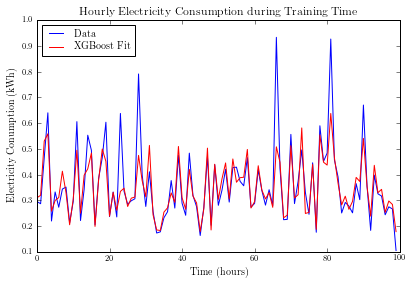

In [27]:
fig, ax = plt.subplots(1)
x = np.arange(100)
ax.plot(x,y_train[0:100], 'b-', label="Data")
ax.plot(x,fit[0:100], 'r-', label="XGBoost Fit")
ax.set_ylabel('Electricity Conumption (kWh)')
ax.set_xlabel('Time (hours)')
ax.legend(loc='best')
ax.set_title('Hourly Electricity Consumption during Training Time')
plt.savefig('figures/xgboost/train.eps')
plt.savefig('figures/xgboost/train.pdf')

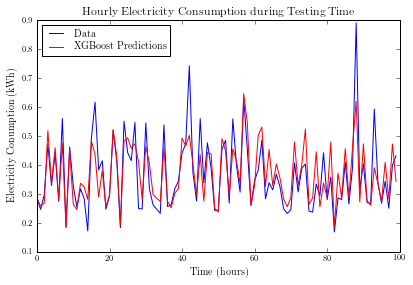

In [28]:
fig, ax = plt.subplots(1)
x = np.arange(100)
ax.plot(x,y_test[0:100], 'b-', label="Data")
ax.plot(x,predictions[0:100], 'r-', label="XGBoost Predictions")
ax.set_ylabel('Electricity Conumption (kWh)')
ax.set_xlabel('Time (hours)')
ax.legend(loc='best')
ax.set_title('Hourly Electricity Consumption during Testing Time')
plt.savefig('figures/xgboost/test.eps')
plt.savefig('figures/xgboost/test.pdf')